In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent.parent
sys.path.append(str(PROJECT_ROOT))
print(f"Project root added to sys.path: {PROJECT_ROOT}")

Project root added to sys.path: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis


In [2]:
from config.settings import *

data_1m_path = DATA_CLEANED_DIR / 'data_1m.csv'
data_5m_path = DATA_CLEANED_DIR / 'data_5m.csv'
data_15m_path = DATA_CLEANED_DIR / 'data_15m.csv'

print(data_1m_path)

D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\data\cleaned\data_1m.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
def check_and_plot_data(df):
    print("\n--- INFO ---")
    print(df.info())
    
    print("\n--- STATISTICS ---")
    print(df.describe())
    
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df['requests_target'], label='Requests (Target)', color='#1f77b4', linewidth=1)
    
    # Highlight vùng Test (Sau ngày 23/08)
    test_start_date = '1995-08-23 00:00:00'
    plt.axvline(pd.to_datetime(test_start_date), color='red', linestyle='--', label='Train/Test Split')
    
    plt.title('Tổng quan dữ liệu Requests', fontsize=14)
    plt.ylabel('Số lượng Request')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [5]:
df_1m = pd.read_csv(data_1m_path, index_col=0, parse_dates=True)
df_5m = pd.read_csv(data_5m_path, index_col=0, parse_dates=True)
df_15m = pd.read_csv(data_15m_path, index_col=0, parse_dates=True)


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87840 entries, 1995-07-02 00:00:00-04:00 to 1995-08-31 23:59:00-04:00
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   requests             87840 non-null  int64  
 1   bytes                87840 non-null  int64  
 2   hosts                87840 non-null  int64  
 3   errors               87840 non-null  int64  
 4   error_rate           87840 non-null  float64
 5   requests_target      87840 non-null  int64  
 6   req_lag_1            87840 non-null  float64
 7   req_lag_12           87840 non-null  float64
 8   req_lag_288          87840 non-null  float64
 9   rolling_mean_1h      87840 non-null  float64
 10  rolling_std_1h       87840 non-null  float64
 11  rolling_mean_24h     87840 non-null  float64
 12  err_lag_1            87840 non-null  float64
 13  err_rolling_mean_1h  87840 non-null  float64
 14  hour_of_day          8784

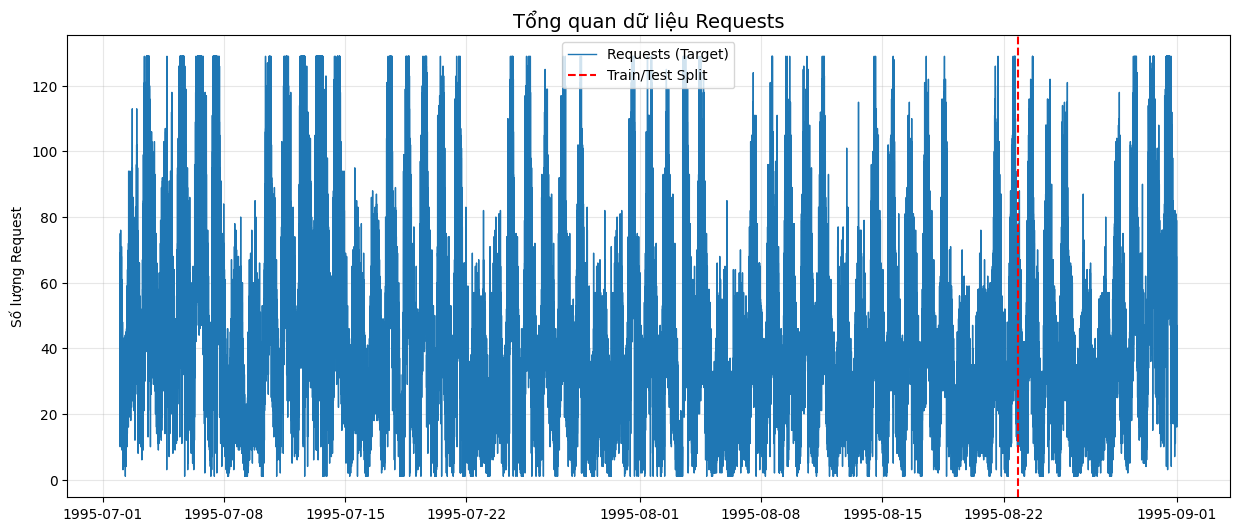

In [6]:
check_and_plot_data(df_1m)


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17568 entries, 1995-07-02 00:00:00-04:00 to 1995-08-31 23:55:00-04:00
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   requests             17568 non-null  int64  
 1   bytes                17568 non-null  int64  
 2   hosts                17568 non-null  int64  
 3   errors               17568 non-null  int64  
 4   error_rate           17568 non-null  float64
 5   requests_target      17568 non-null  int64  
 6   req_lag_1            17568 non-null  float64
 7   req_lag_12           17568 non-null  float64
 8   req_lag_288          17568 non-null  float64
 9   rolling_mean_1h      17568 non-null  float64
 10  rolling_std_1h       17568 non-null  float64
 11  rolling_mean_24h     17568 non-null  float64
 12  err_lag_1            17568 non-null  float64
 13  err_rolling_mean_1h  17568 non-null  float64
 14  hour_of_day          1756

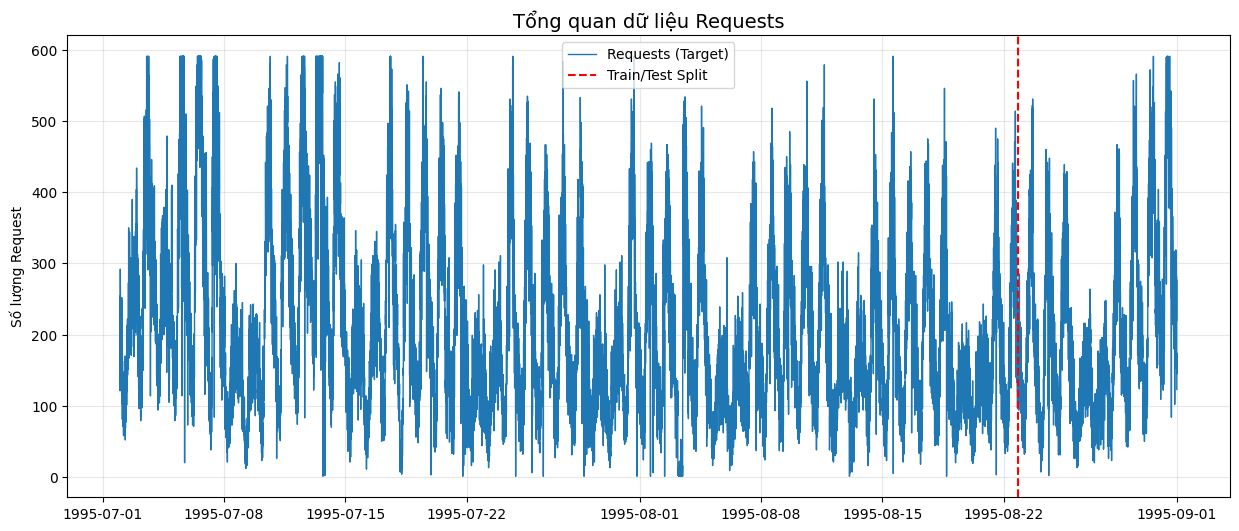

In [7]:
check_and_plot_data(df_5m)


--- INFO ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 1995-07-02 00:00:00-04:00 to 1995-08-31 23:45:00-04:00
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   requests             5856 non-null   int64  
 1   bytes                5856 non-null   int64  
 2   hosts                5856 non-null   int64  
 3   errors               5856 non-null   int64  
 4   error_rate           5856 non-null   float64
 5   requests_target      5856 non-null   int64  
 6   req_lag_1            5856 non-null   float64
 7   req_lag_12           5856 non-null   float64
 8   req_lag_288          5856 non-null   float64
 9   rolling_mean_1h      5856 non-null   float64
 10  rolling_std_1h       5856 non-null   float64
 11  rolling_mean_24h     5856 non-null   float64
 12  err_lag_1            5856 non-null   float64
 13  err_rolling_mean_1h  5856 non-null   float64
 14  hour_of_day          5856 

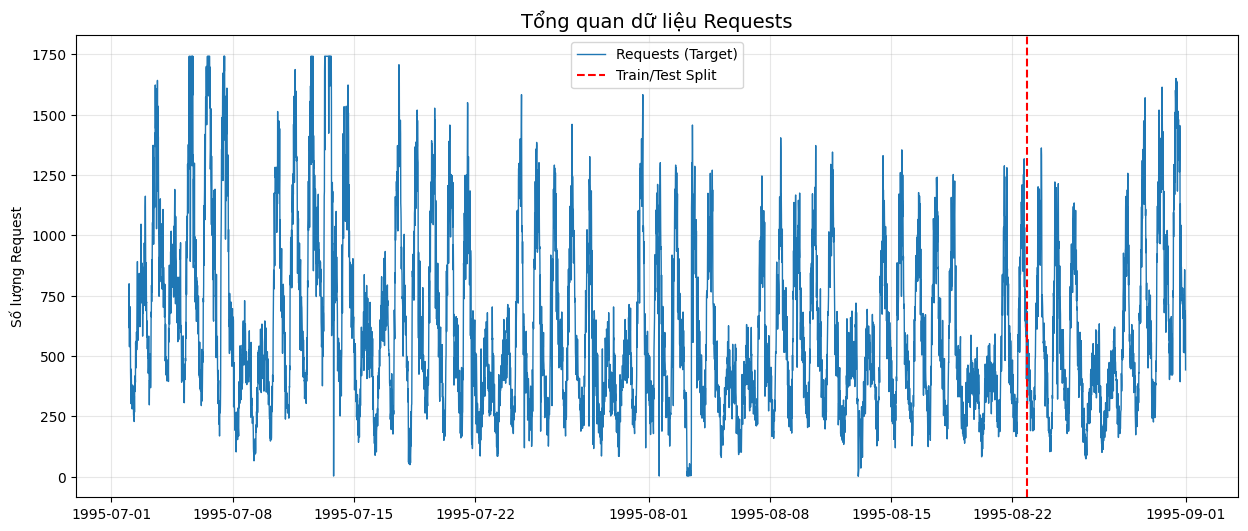

In [8]:
check_and_plot_data(df_15m)

In [9]:
df_5m.head(2)

,requests,bytes,hosts,errors,error_rate,requests_target,req_lag_1,req_lag_12,req_lag_288,rolling_mean_1h,rolling_std_1h,rolling_mean_24h,err_lag_1,err_rolling_mean_1h,hour_of_day,day_of_week,is_weekend,hour_sin,hour_cos,is_spike
timestamp,,,,,,,,,,,,,,,,,,,,
1995-07-02 00:00:00-04:00,243,4199114,50,3,0.012346,243,149.0,232.0,301.0,238.666667,56.633324,224.500000,0.013423,0.004610,0,6,1,0.0,1.0,0
1995-07-02 00:05:00-04:00,254,6328419,60,1,0.003937,254,243.0,235.0,267.0,240.250000,56.786882,224.454861,0.012346,0.004938,0,6,1,0.0,1.0,0


hour_cos      0.449940
is_weekend    0.322269
hour_sin      0.181027
error_rate    0.046764
dtype: float64


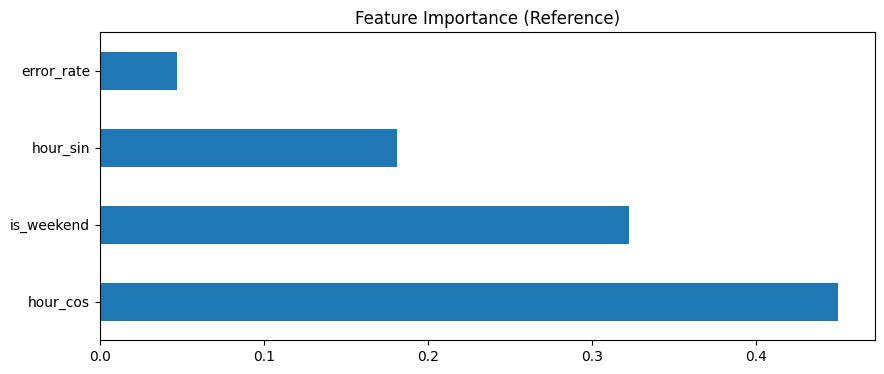


-> Features selected for LSTM: ['requests_target', 'error_rate', 'hour_sin', 'hour_cos', 'is_weekend']


In [10]:
def select_features_lstm(df):
    potential_cols = [ 'error_rate', 'hour_sin', 'hour_cos', 'is_weekend']
    
    X_check = df[potential_cols]
    y_check = df['requests_target']
    
    rf = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
    rf.fit(X_check, y_check)
    
    importances = pd.Series(rf.feature_importances_, index=potential_cols).sort_values(ascending=False)
    print(importances)
    plt.figure(figsize=(10, 4))
    importances.plot(kind='barh', title='Feature Importance (Reference)')
    plt.show()
 
    selected_features = ['requests_target', 'error_rate', 'hour_sin', 'hour_cos', 'is_weekend']
    print(f"\n-> Features selected for LSTM: {selected_features}")
    
    return df[selected_features]

df_lstm_input = select_features_lstm(df_5m)

In [11]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length=12):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length

    def __getitem__(self, i):
        return self.X[i : i + self.sequence_length], self.y[i + self.sequence_length]

def prepare_data_pipeline(df, sequence_length=12, batch_size=32):
    """
    Quy trình: Split -> Scale -> Windowing -> DataLoader
    Tách: Train / Validation / Test
    """
    # Train: đến 16/08 (60%)
    # Validation: 17/08 - 22/08 (20%)
    # Test: từ 23/08 (20%)
    train_cutoff = '1995-08-16 23:59:59'
    val_cutoff = '1995-08-22 23:59:59'
    
    train_df = df[df.index <= train_cutoff]
    val_df = df[(df.index > train_cutoff) & (df.index <= val_cutoff)]
    test_df = df[df.index > val_cutoff]
    
    print(f"Train size: {len(train_df)} | Validation size: {len(val_df)} | Test size: {len(test_df)}")
    
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))
    
    # Fit scalers on training data only
    scaler_features.fit(train_df)
    scaler_target.fit(train_df[['requests_target']])
    
    train_scaled = scaler_features.transform(train_df)
    val_scaled = scaler_features.transform(val_df)
    test_scaled = scaler_features.transform(test_df)
    
   
    train_dataset = TimeSeriesDataset(train_scaled, train_scaled[:, 0], sequence_length)
    val_dataset = TimeSeriesDataset(val_scaled, val_scaled[:, 0], sequence_length)
    test_dataset = TimeSeriesDataset(test_scaled, test_scaled[:, 0], sequence_length)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 
    
    return train_loader, val_loader, test_loader, scaler_target, scaler_features

In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
      
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        # Lấy output tại bước thời gian cuối cùng (Last time step)
        out = out[:, -1, :]
        
        # Đưa qua lớp Dense
        out = self.fc(out)
        return out

In [13]:
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

In [14]:
def save_model_weights(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model weights saved to: {filepath}")


def load_model_weights(model, filepath):
    model.load_state_dict(torch.load(filepath, map_location=device))
    print(f"Model weights loaded from: {filepath}")
    return model


def train(model, train_loader, val_loader, epochs=20, lr=0.001, 
          patience=5, model_save_path=None):
    """
    Training model với Early Stopping trên Validation Set
    
    Parameters:
    model : torch.nn.Module
        LSTM model
    train_loader : DataLoader
        Training data loader
    val_loader : DataLoader
        Validation data loader (dùng cho early stopping)
    epochs : int
        Số epoch tối đa (default: 20)
    lr : float
        Learning rate (default: 0.001)
    patience : int
        Số epoch không cải thiện trước khi dừng (default: 5)
    model_save_path : str or Path
        Đường dẫn để lưu model weights tốt nhất (default: None - không lưu)
        
    Returns:
    --------
    dict : Dictionary chứa:
        - 'model': model đã train
        - 'train_losses': list train losses
        - 'val_losses': list validation losses
        - 'best_epoch': epoch có validation loss tốt nhất
        - 'best_val_loss': validation loss tốt nhất
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0
    
    print(f"Patience: {patience} epochs | Save path: {model_save_path}")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # 1. Forward
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            
            # 2. Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                loss = criterion(outputs.squeeze(), y_val)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
      
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch + 1
            patience_counter = 0
            
            # Save best model weights
            if model_save_path is not None:
                save_model_weights(model, model_save_path)
                print(f'Epoch [{epoch+1}/{epochs}] ✓ Best Model! Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
            else:
                print(f'Epoch [{epoch+1}/{epochs}] ✓ Best! Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}')
        else:
            patience_counter += 1
            if (epoch+1) % 5 == 0:
                print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f} (Patience: {patience_counter}/{patience})')
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\n⚠️  Early Stopping! No improvement for {patience} epochs.")
            print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")
            break
    
    if model_save_path is not None:
        print(f"\nLoading best model weights from epoch {best_epoch}...")
        model = load_model_weights(model, model_save_path)
    
   
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(val_losses, label='Validation Loss', linewidth=2)
    plt.axvline(best_epoch-1, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Model Learning Curve with Early Stopping')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'model': model,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_epoch': best_epoch,
        'best_val_loss': best_val_loss,
    }


def evaluate(model, test_loader, scaler_target):
    """
    Returns:
    --------
    dict : Dictionary chứa:
        - 'predictions': array predictions (đơn vị thực tế)
        - 'actuals': array actual values (đơn vị thực tế)
        - 'metrics': dict chứa rmse, mse, mae, mape
    """
    print("\n--- EVALUATION ON TEST SET ---")
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            # Move về CPU và convert sang numpy
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(y_batch.numpy())
            
    # Inverse Transform về đơn vị request thực tế
    predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))
    
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = calculate_mape(actuals, predictions)
    
    print(f"RMSE: {rmse:.2f}")
    print(f"MSE:  {mse:.2f}")
    print(f"MAE:  {mae:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    # ===========================
    # Plot Predictions vs Actuals
    # ===========================
    plt.figure(figsize=(15, 6))
    plt.plot(actuals[:300], label='Actual Request', color='blue', linewidth=1.5)
    plt.plot(predictions[:300], label='LSTM Forecast', color='orange', linestyle='--', linewidth=1.5)
    plt.title('Dự báo vs Thực tế (Zoom in 300 điểm dữ liệu đầu tập Test)')
    plt.xlabel('Time Steps')
    plt.ylabel('Requests')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # ===========================
    # Plot Full Predictions
    # ===========================
    plt.figure(figsize=(15, 6))
    plt.plot(actuals, label='Actual Request', color='blue', linewidth=0.8, alpha=0.8)
    plt.plot(predictions, label='LSTM Forecast', color='orange', linestyle='--', linewidth=0.8, alpha=0.8)
    plt.title('Full Predictions vs Actuals trên toàn bộ tập Test')
    plt.xlabel('Time Steps')
    plt.ylabel('Requests')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return {
        'predictions': predictions,
        'actuals': actuals,
        'metrics': {
            'rmse': rmse,
            'mse': mse,
            'mae': mae,
            'mape': mape
        }
    }

In [15]:
train_loader, val_loader, test_loader, scaler_target, scaler_features = prepare_data_pipeline(
    df_lstm_input,
    sequence_length=12,
    batch_size=32
)


Train size: 13248 | Validation size: 1728 | Test size: 2592


In [16]:
model = LSTMModel(
    input_size=5,           # 5 features: requests_target, error_rate, hour_sin, hour_cos, is_weekend
    hidden_size=64,
    num_layers=2,
    dropout=0.2
)
model = model.to(device)

print(f"Model Architecture:\n{model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model Architecture:
LSTMModel(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Total parameters: 51,521


Patience: 10 epochs | Save path: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\lstm_5m_best_model.pth
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\lstm_5m_best_model.pth
Epoch [1/50] ✓ Best Model! Train Loss: 0.013748, Val Loss: 0.005883
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\lstm_5m_best_model.pth
Epoch [2/50] ✓ Best Model! Train Loss: 0.008395, Val Loss: 0.005845
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\lstm_5m_best_model.pth
Epoch [3/50] ✓ Best Model! Train Loss: 0.008026, Val Loss: 0.005778
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\lstm_5m_best_model.pth
Epoch [4/50] ✓ Best Model! Train Loss: 0.007609, Val Loss: 0.005493
Epoch [5/50] Train Loss: 0.007436, Val Loss: 0.006040 (Patience: 1/10)
Model weights saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\models\lstm_5m_best_mode

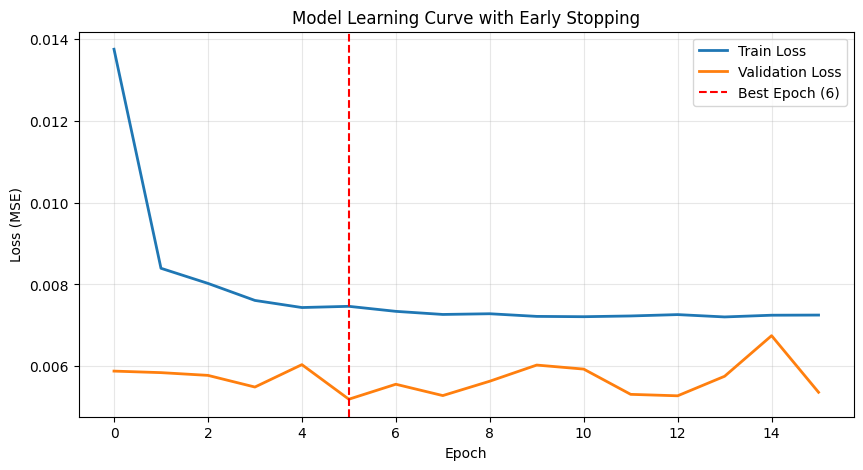


✓ Training completed!
Best Epoch: 6
Best Validation Loss: 0.005195


In [17]:
model_save_path = MODELS_DIR / 'lstm_5m_best_model.pth'

train_result = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=50,
    lr=0.001,
    patience=10,
    model_save_path=model_save_path
)

print(f"\n✓ Training completed!")
print(f"Best Epoch: {train_result['best_epoch']}")
print(f"Best Validation Loss: {train_result['best_val_loss']:.6f}")



--- EVALUATION ON TEST SET ---
RMSE: 44.59
MSE:  1988.19
MAE:  33.93
MAPE: 27.59%


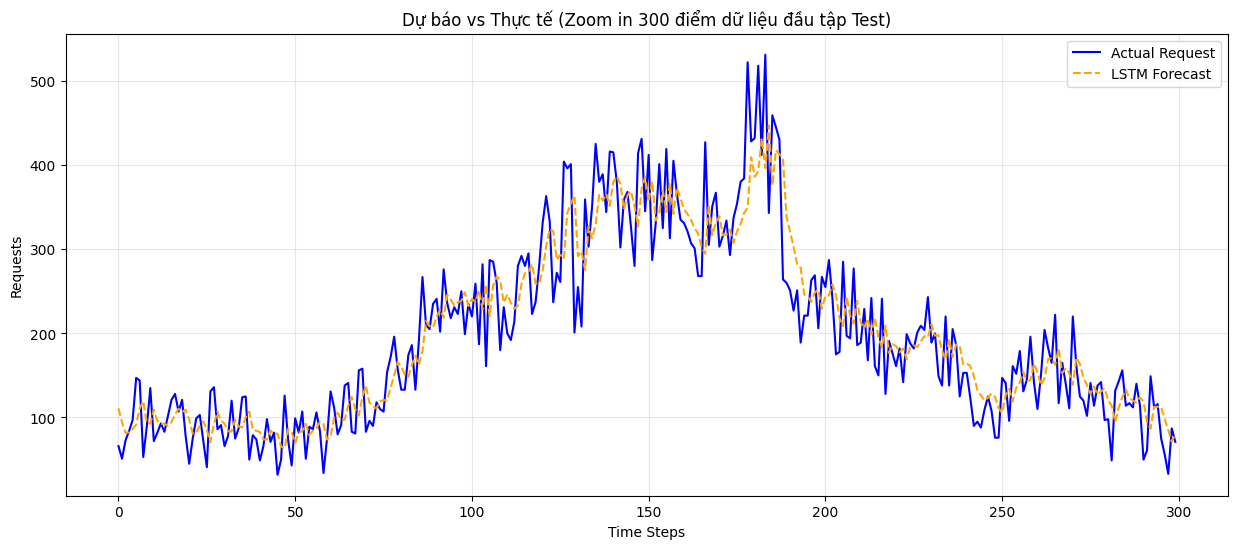

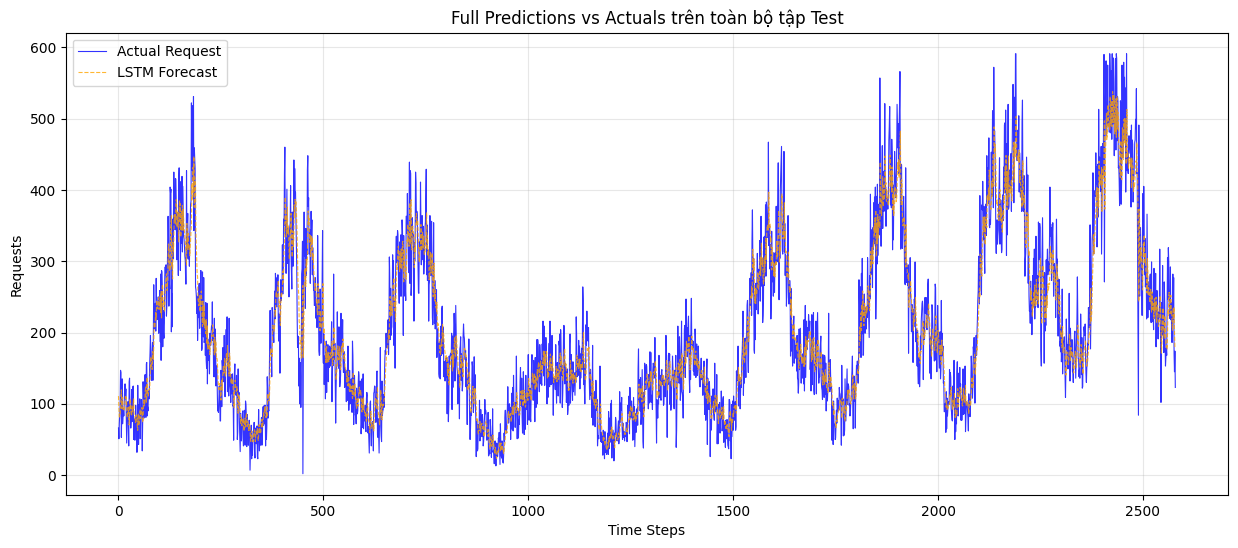


✓ Evaluation completed!

Test Set Metrics:
  RMSE: 44.59
  MAE:  33.93
  MAPE: 27.59%


In [18]:
eval_result = evaluate(
    model=train_result['model'],
    test_loader=test_loader,
    scaler_target=scaler_target
)

print(f"\n✓ Evaluation completed!")
print(f"\nTest Set Metrics:")
print(f"  RMSE: {eval_result['metrics']['rmse']:.2f}")
print(f"  MAE:  {eval_result['metrics']['mae']:.2f}")
print(f"  MAPE: {eval_result['metrics']['mape']:.2f}%")


In [19]:
import json
from datetime import datetime

# Create results summary
results_summary = {
    'timestamp': datetime.now().isoformat(),
    'model_config': {
        'input_size': 5,
        'hidden_size': 64,
        'num_layers': 2,
        'dropout': 0.2
    },
    'training_config': {
        'epochs': 50,
        'batch_size': 32,
        'learning_rate': 0.001,
        'patience': 5,
        'sequence_length': 12
    },
    'training_results': {
        'best_epoch': train_result['best_epoch'],
        'best_val_loss': float(train_result['best_val_loss']),
        'num_epochs_trained': len(train_result['train_losses'])
    },
    'test_metrics': {
        'rmse': float(eval_result['metrics']['rmse']),
        'mse': float(eval_result['metrics']['mse']),
        'mae': float(eval_result['metrics']['mae']),
        'mape': float(eval_result['metrics']['mape'])
    }
}

# Save to JSON
results_path = OUTPUT_DIR / 'lstm_5m_results.json'
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=4)

print(f"✓ Results saved to: {results_path}")
print(f"\nFinal Summary:")
print(json.dumps(results_summary, indent=2))


✓ Results saved to: D:\Documents\AutoScaling Analysis\Autoscaling-Analysis\output\lstm_5m_results.json

Final Summary:
{
  "timestamp": "2026-02-03T01:29:32.546285",
  "model_config": {
    "input_size": 5,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0.2
  },
  "training_config": {
    "epochs": 50,
    "batch_size": 32,
    "learning_rate": 0.001,
    "patience": 5,
    "sequence_length": 12
  },
  "training_results": {
    "best_epoch": 6,
    "best_val_loss": 0.005195347623494281,
    "num_epochs_trained": 16
  },
  "test_metrics": {
    "rmse": 44.589098938424684,
    "mse": 1988.187744140625,
    "mae": 33.92972183227539,
    "mape": 27.590011596679688
  }
}
